In [462]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib

import fates_calibration_library.analysis_functions as analysis
import fates_calibration_library.oaat_functions as oaat
import fates_calibration_library.plotting_functions as plotting
import fates_calibration_library.utils as utils

In [596]:
import importlib
import fates_calibration_library.oaat_functions
import fates_calibration_library.plotting_functions
importlib.reload(fates_calibration_library.oaat_functions)
importlib.reload(fates_calibration_library.analysis_functions)
importlib.reload(fates_calibration_library.plotting_functions)

<module 'fates_calibration_library.plotting_functions' from '/glade/work/afoster/FATES_calibration/fates_calibration_library/fates_calibration_library/plotting_functions.py'>

In [597]:
# parameter directory
param_dir = '/glade/work/afoster/FATES_calibration/parameter_files'

# history output directory
hist_dir = '/glade/work/afoster/FATES_calibration/history_files'

ensemble_dict = {
    'fates': {
        'param_list': os.path.join(param_dir, "param_list_sci.1.81.1_api.38.0.0.xls"),
        'key': os.path.join(param_dir, 'fates_oaat', 'fates_oaat_key.csv'),
        'name': 'fates_oaat',
    },
    'fates_clmpars': {
        'param_list': os.path.join(param_dir, 'CLM5_Parameter_List.csv'),
        'key': os.path.join(param_dir, 'clm6sp_oaat_key.csv'),
        'name': 'fates_oaat_clmpars',
    }
}

# config file with variable information in it
var_config = '/glade/work/afoster/FATES_calibration/fates_calibration_library/configs/model_conversion.yaml'
var_dict = utils.get_config_file(var_config)

In [598]:
out_vars = ['GPP', 'EFLX_LH_TOT', 'FSH', 'EF', 'SOILWATER_10CM',
            'ASA', 'FSR', 'FSA', 'FIRE', 'RLNS', 'RN', 'BTRANMN',
            'TV']

In [599]:
fates_key = pd.read_csv(ensemble_dict['fates']['key'], index_col=0)
fates_param_dat = oaat.get_fates_param_dat(ensemble_dict['fates']['param_list'], fates_key)

In [600]:
clm_param_dat = oaat.get_clm_param_dat(ensemble_dict['fates_clmpars']['param_list'])

In [601]:
clm_param_dat

<xarray.Dataset>
Dimensions:         (ensemble: 397)
Coordinates:
  * ensemble        (ensemble) int64 29 30 89 133 134 194 ... 42 43 31 32 34 33
Data variables:
    parameter_name  (ensemble) object 'a_coef' 'a_exp' ... 'zsno' 'zsno'
    type            (ensemble) object 'min' 'max' 'max' ... 'max' 'max' 'min'
    category        (ensemble) object 'biophysics' 'biophysics' ... 'biophysics'
    subcategory     (ensemble) object 'latent' 'latent' ... 'latent' 'latent'

In [602]:
area_means = xr.open_dataset(os.path.join(hist_dir,
                                          f"{ensemble_dict['fates_clmpars']['name']}_area_means.nc"))

In [603]:
area_means = oaat.get_area_means_diffs(area_means, clm_param_dat, out_vars, 206)

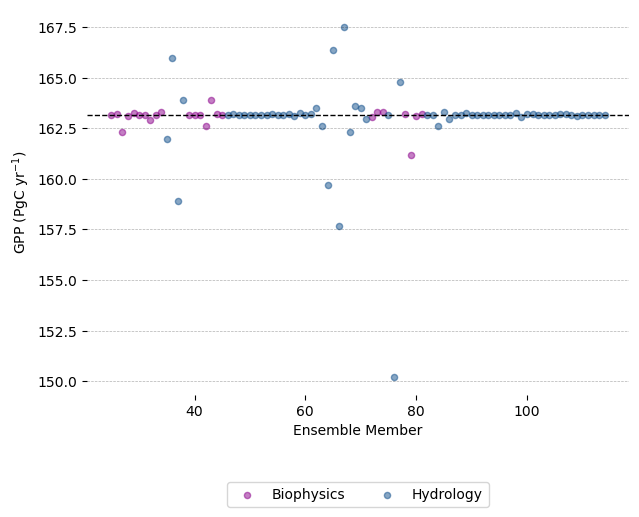

In [604]:
variable = out_vars[0]
plotting.plot_area_means(area_means, 206, 'mean', variable,
                         var_dict[variable]['long_name'],
                         var_dict[variable]['global_units'])

In [605]:
# get rid of default simulation
ds_mean = area_means.where(area_means.ensemble > 0, drop=True).sel(summation_var='mean')
df_meandiffs = oaat.get_min_max_diff(ds_mean)

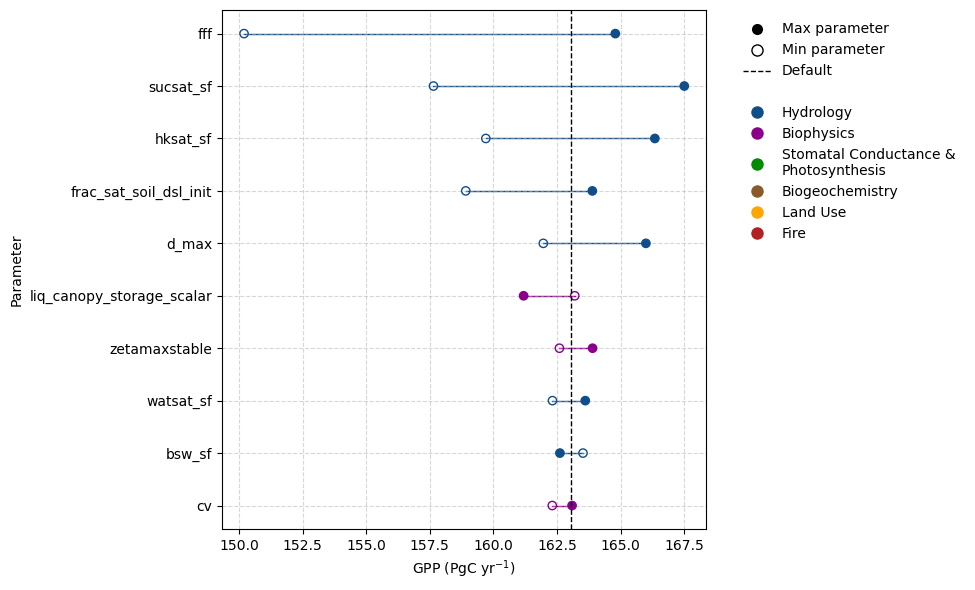

In [606]:
variable = 'GPP'
top10 = oaat.get_top_n(ds_mean, df_meandiffs, variable, 10)
plotting.plot_top_n(top10, area_means.isel(ensemble=0).sel(summation_var='mean'),
           variable, var_dict[variable]['long_name'], var_dict[variable]['global_units'])

In [448]:
def get_ensemble_slopes(ds, default_ind, skip_vars=['category', 'subcategory', 'type', 'parameter_name']):
    if skip_vars is None:
        skip_vars = []
    slope_start_vars = {}
    slope_end_vars = {}

    for variable in ds.data_vars:
        if variable in skip_vars:
            continue
        if 'month' not in ds[variable].dims:
            continue
        try:
            infl_months = analysis.compute_infl(ds[variable].mean(dim='ensemble'))
            slopes_start = []
            slopes_end = []
            for ens in ds.ensemble.values:
                da_ens = ds[variable].sel(ensemble=ens)
                slope_start, slope_end = analysis.get_start_end_slopes(da_ens, infl_months)
                slopes_start.append(slope_start)
                slopes_end.append(slope_end)
            
            slope_start_da = xr.DataArray(slopes_start, 
                                          coords={'ensemble': ds.ensemble},
                                          dims='ensemble')
            slope_end_da = xr.DataArray(slopes_end, 
                                        coords={'ensemble': ds.ensemble},
                                        dims='ensemble')
            start_default = slope_start_da.sel(ensemble=default_ind)
            end_default = slope_end_da.sel(ensemble=default_ind)
            slope_start_vars[variable] = slope_start_da
            slope_end_vars[variable] = slope_end_da
            
        except Exception as e:
            print(f"Skipping variable {variable} due to error: {e}")
            continue
    
    slope_start_ds = xr.Dataset(slope_start_vars)
    slope_end_ds = xr.Dataset(slope_end_vars)
    
    return slope_start_ds, slope_end_ds

In [445]:
climatology_ds = climatology.where(climatology.ensemble > 0, drop=True)

In [450]:
start, end = get_ensemble_slopes(climatology_ds, 1)
start = xr.merge([start, fates_param_info])
end = xr.merge([end, fates_param_info])

In [451]:
start_diffs = oaat.get_min_max_diff(start)

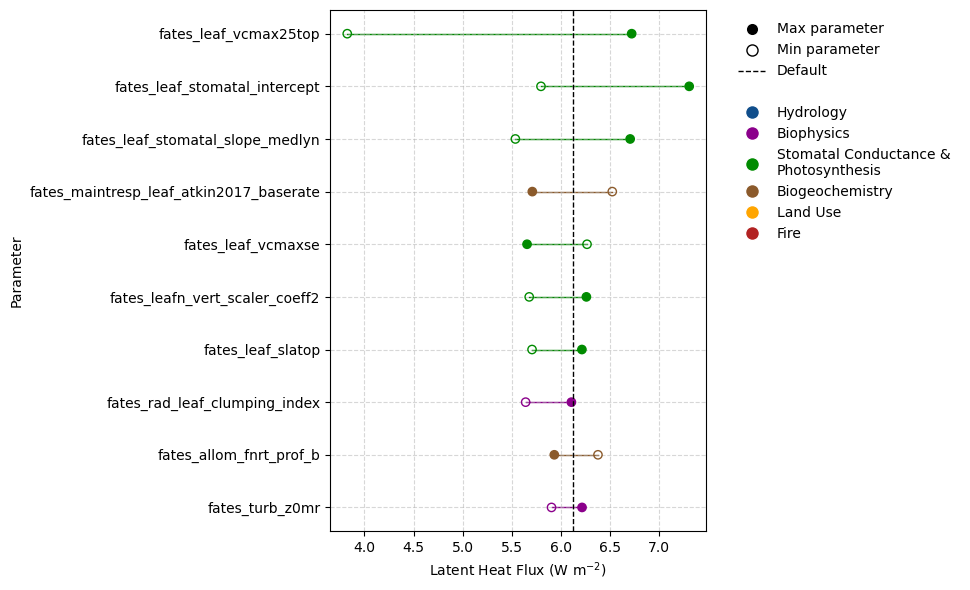

In [461]:
variable = 'EFLX_LH_TOT'
top10 = oaat.get_top_n(start, start_diffs, variable, 10)
plotting.plot_top_n(top10, start, variable, var_dict[variable]['long_name'], 
                    var_dict[variable]['global_units'])

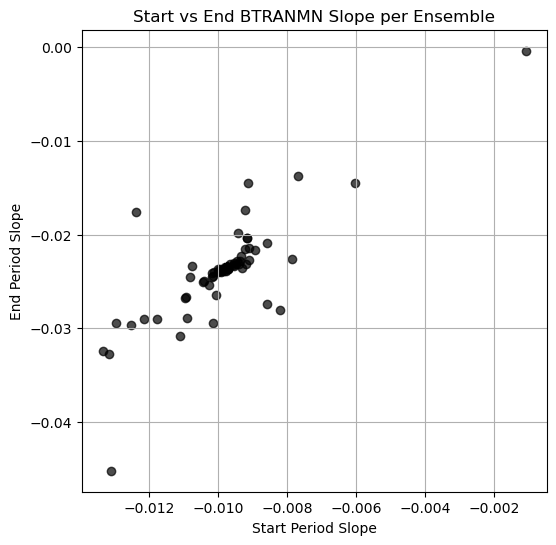

In [397]:
plt.figure(figsize=(6, 6))
plt.scatter(start.GPP, end.GPP, alpha=0.7, c='k')
#plt.scatter(start_default, end_default, c='red')
plt.xlabel("Start Period Slope")
plt.ylabel("End Period Slope")
plt.title(f"Start vs End {variable} Slope per Ensemble")
plt.grid(True)

In [13]:
from adjustText import adjust_text

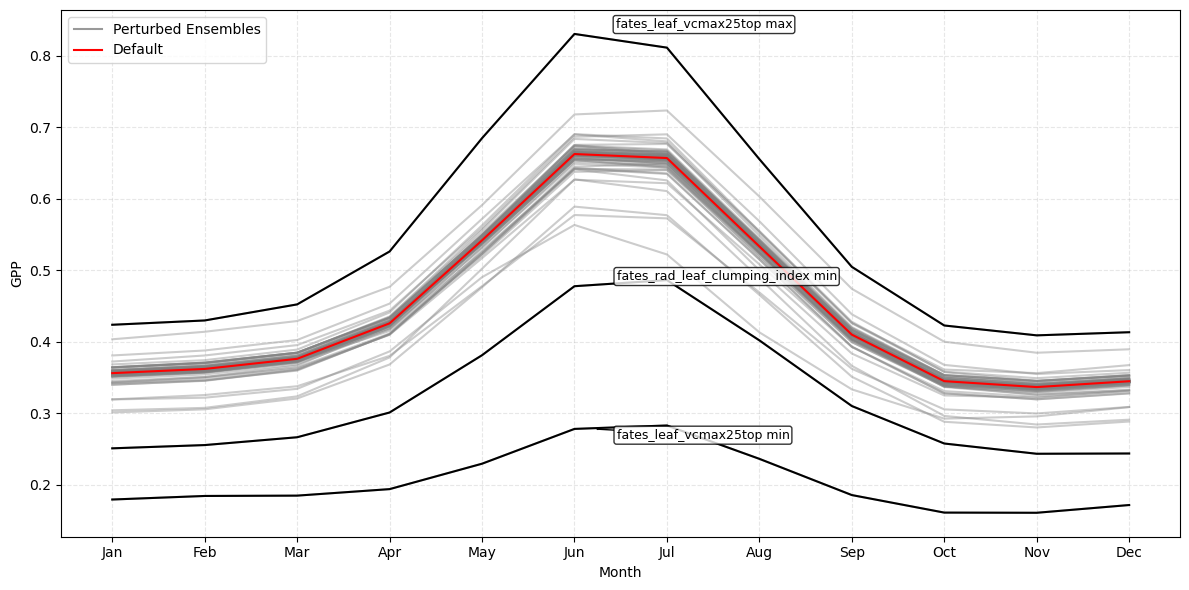

In [267]:
variable = 'GPP'
default = climatology.sel(ensemble=0)

interesting_ensembles = [117, 118, 203]
texts = []

plt.figure(figsize=(12, 6))

for ens in climatology_ds.ensemble.values:
    sub = climatology_ds.sel(ensemble=ens)
    plt.plot(sub[variable].month, sub[variable], color='gray', alpha=0.4)

plt.plot(default[variable].month, default[variable], color='red')
plt.plot([], [], color='k', alpha=0.4, label='Perturbed Ensembles')
plt.plot([], [], color='red', label='Default')

# Highlight & annotate interesting ensembles
for ens in interesting_ensembles:
    sub = climatology_ds.sel(ensemble=ens)
    param_name = climatology_ds.sel(ensemble=ens).parameter_name.values
    type = climatology_ds.sel(ensemble=ens).type.values
    label = f'{param_name} {type}'
    line = plt.plot(sub[variable].month, sub[variable], color='k')[0]

    x = 6
    y = sub[variable].sel(month=x).values
    texts.append(
        plt.text(
            x + 0.2, y, label,
            fontsize=9,
            bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='black', alpha=0.8)
        )
    )
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='->', color='black'),
    only_move={'points': 'y', 'texts': 'xy'}
)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='upper left')
plt.xlabel('Month')
plt.ylabel('GPP')
plt.xticks(ticks=range(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.tight_layout()